# K-Nearest Neighbours and K-Means Clustering

In this exercise, we shall use k-nearest neighbours (KNN) and k-means clustering for classficiation of digits from the MNIST handwritten dataset. 

KNN is a supervised learning method, whereas k-means clustering is an unsupervised learning method. 

In [15]:
#optional if the following error arises with sklearn implemenations:
#AttributeError: 'NoneType' object has no attribute 'split'
# refer the link: 
# https://stackoverflow.com/questions/71352354/sklearn-kmeans-is-not-working-as-i-only-get-nonetype-object-has-no-attribute

! pip install threadpoolctl==3.1.0

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [16]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
import random

%matplotlib inline

In [17]:
# Will not work until a Python script named 'MyPCA.py' is created
# which contains the PCA class from the exercise 02.

# If such a file does not exist, use sklearn's PCA implementation as disccused in exercise 02

#import the PCA class implemention
from MyPCA import *

In [18]:
# import MNIST dataset (might take a few seconds)

from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, parser = 'auto')

# check the datatype and shape of the data
print(type(images), images.shape)
print(type(labels), labels.shape)

# if not in NumPy, convert the data to NumPy array

images = np.array(images)
labels = np.array(labels)

# check the shape of an individual image sample
print(type(images[0]), images[0].shape)
print(type(labels[0]), labels[0])

# select 2000 samples from the whole MNIST dataset
num_datapoints = 2000
# some preprocessing
X = (images.reshape(-1, 28*28)[:num_datapoints])/ 255 
# dividing by 255 will scale pixel values between [0, 1]
y = labels.astype(float) #convert string labels to float
y = y[:num_datapoints]

<class 'pandas.core.frame.DataFrame'> (70000, 784)
<class 'pandas.core.series.Series'> (70000,)
<class 'numpy.ndarray'> (784,)
<class 'str'> 5


In [19]:
# Show counts of samples for each digit among the 2000 samples

labels_unique = np.unique(y)
counts = []
for label in labels_unique:
    count = np.sum(y == label)
    counts.append(count)
    print("Label: ", label, "| count: ", count)

print("total samples: ", sum(counts))

Label:  0.0 | count:  191
Label:  1.0 | count:  220
Label:  2.0 | count:  198
Label:  3.0 | count:  191
Label:  4.0 | count:  214
Label:  5.0 | count:  180
Label:  6.0 | count:  200
Label:  7.0 | count:  224
Label:  8.0 | count:  172
Label:  9.0 | count:  210
total samples:  2000


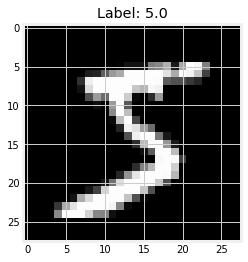

In [20]:
# plot an image
def image_plotter(X, labels, ix):
    plt.figure(figsize = (4, 4))
    plt.imshow(X[ix].reshape(28, 28), cmap = 'gray')
    plt.title('Label: '+ str(labels[ix]))
    
image_plotter(X, y, 0)

In [21]:
def extract_digits(X, y, classes, samples_per_class):
    """
    Extract specified number of samples for each given digit from the MNIST dataset.

    Parameters:
    - X (np.array): Array of images from MNIST dataset.
    - y (np.array): Corresponding labels for the MNIST dataset images.
    - classes (list of int): List of digits to extract (e.g., [0, 1, 2]).
    - samples_per_class (int): Number of samples to extract for each class.

    Returns:
    - tuple of np.array: Tuple containing the extracted features matrix and labels vector.
    """
    X_extracted = []
    y_extracted = []
    
    for digit in classes:
        # Find the indices where the label equals the current digit
        indices = np.where(y == digit)[0]
        
        # Check if there are enough samples available
        if len(indices) < samples_per_class:
            raise ValueError(f"Not enough samples for digit {digit}. Only {len(indices)} available.")
        
        # Extract the samples for this digit
        selected_indices = indices[:samples_per_class]
        X_extracted.append(X[selected_indices])
        y_extracted.append(y[selected_indices])
    
    # Concatenate lists into arrays
    X_extracted = np.concatenate(X_extracted, axis=0)
    y_extracted = np.concatenate(y_extracted, axis=0)
    
    return X_extracted, y_extracted

In [22]:
classes = [1, 7, 3]  # Digits to extract
samples_per_class = 100 # Number of samples per digit

X_classes, y_classes = extract_digits(X, y, classes, samples_per_class)
print(X_classes.shape, y_classes.shape)  # Check the shape of the extracted arrays
print(y_classes[y_classes == 1].shape)

(300, 784) (300,)
(100,)


index:  285 Label:  3.0


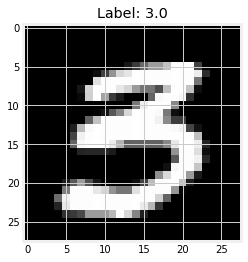

In [23]:
# plot a random image
ix_l = np.random.randint(0, len(X_classes))
print("index: ", ix_l, "Label: ", y_classes[ix_l])
image_plotter(X_classes, y_classes, ix_l)

In [24]:
# function to plot scatter plot of all the samples in dataset with labels

def scatter_plot(colors_labels, X, y, title = 'Plot of samples'):
    
    
    fig, ax = plt.subplots()

    # Set to keep track of which labels have been added to the legend
    legend_labels = set()

    for point, label in zip(X, y):
        if label not in legend_labels:
            ax.scatter(point[0], point[1], c=colors[label], label=label)
            legend_labels.add(label)  # Mark this label as added
        else:
            ax.scatter(point[0], point[1], c=colors[label])

    # Add a legend, labels, and title
    ax.legend(title='Label')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title(title)
    plt.show()

In [25]:
# create train and test datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_classes, y_classes, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape)

(201, 784) (99, 784)


## k-nearest neighbours classification (supervised learning)

The k-nearest neighbors (k-NN) classification algorithm is a type of instance-based learning, where the function is only approximated locally and all computation is deferred until classification.

Given a new data point $x$, the algorithm finds the $k$ training examples that are closest to it in terms of distance, and then predicts the output based on the outputs of these $k$ neighbors. Let $N_k(x)$ be the set of $k$ nearest neighbors of $x$, and let $y_i$ be the output of the $i$-th nearest neighbor. The predicted output $\hat{y}$ is given by:

$$
\hat{y} = \text{mode}\{y_i : x_i \in N_k(x)\}
$$

where $\text{mode}\{.\}$ is the mode function that returns the most common value among its arguments.

The distance between two data points can be measured using various distance metrics, such as Euclidean distance, Manhattan distance, or Minkowski distance. The choice of distance metric depends on the problem at hand.

In summary, k-nearest neighbors classification works by finding the $k$ nearest neighbors of a new data point and predicting the output based on the most common output among these neighbors.


Some definitions:

1. *Instance based learning*: it makes predictions based on the specific instances of the training data, rather than constructing a general model that captures the underlying relationship between the input and output variables.

2. *Function is only approximated locally*: the prediction for a new data point is based on the outputs of its k nearest neighbors in the training data. This is in contrast to other machine learning algorithms, such as linear regression or decision trees, where a global model is constructed to approximate the function over the entire input space.

### Illustration

![KNN_Illustration](KNN_Illustration.png)


### Algorithm:

1) Select the number of k neighbors.

2) Calculate Euclidean distance of each sample w.r.t all other samples of the dataset.

3) For each sample, sort the distances in ascending order, and select the k nearest neighbors. 

4) Find the most frequent label amongst the k nearest neighbors to each sample. Assign that as the label of that sample. 


In [26]:
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator
from scipy.stats import mode


def most_common(lst):
    """
    Find the mode of the labels.
    Args:
    - lst: list of labels.
    
    Returns:
    - The most frequent label.
    """
    #return #max(set(lst), key=lst.count)
    return mode(lst).mode[0]

def euclidean(point, data):
    """
    Compute the Euclidean distance between a point and all points in a dataset.
    Args:
    - point: A numpy array representing the test sample.
    - data: A numpy array representing the training samples.
    
    Returns:
    - distances: Numpy array of distances.
    """
    #TASK: Compute the euclidean distance between a point and all points of the dataset
    distances = None
    
    
    return distances

class My_KNeighborsClassifier(BaseEstimator):
    def __init__(self, k=5, dist_metric=euclidean):
        """
        Initialize the KNeighborsClassifier.
        Args:
        - k: Number of neighbors to consider.
        - dist_metric: Function to compute the distance.
        """
        self.k = k
        self.dist_metric = dist_metric
        self.is_fitted_ = False  # Attribute to track if the estimator is fitted

    def fit(self, X_train, y_train):
        """
        Fit the KNeighbors classifier with the training data.
        Args:
        - X_train: Training data features.
        - y_train: Training data labels.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.is_fitted_ = True  # Indicate that fitting is complete

    def predict(self, X_test):
        """
        Predict the class labels for the test set.
        Args:
        - X_test: Test data features.
        
        Returns:
        - predictions: Numpy array of predicted labels.
        """
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        for x in X_test:
            # TASK: Compute distances from x to all training samples
            distances = None  # Replace None with your code using self.dist_metric

            # TASK: Sort the training labels by distance and select the k nearest
            k_nearest_labels = None  # Replace None with your code to sort and select k nearest

            # TASK: Find the most common label among the k nearest labels
            predicted_label = None  # Replace None with your code using most_common

            predictions.append(predicted_label)
        return np.array(predictions)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the accuracy of the classifier.
        Args:
        - X_test: Test data features.
        - y_test: Test data labels.
        
        Returns:
        - accuracy: The accuracy of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = None  # TASK: Compute the accuracy of the predictions
        return accuracy




In [27]:
# Requires MyPCA class implementation

# Preprocess data
mypca = MyPCA(2)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)



In [28]:
# WILL NOT RUN UNTIL THE CODE BLOCK ABOVE IS COMPLETED

# Use the KNeighborsClassifier class 

my_knn = My_KNeighborsClassifier(k=5)
my_knn.fit(X_train_reduced, y_train)
y_test_pred_my_knn = my_knn.predict(X_test_reduced)
test_accuracy_my_knn = my_knn.evaluate(X_test_reduced, y_test)
print("Test accuracy my knn: ", test_accuracy_my_knn.round(4))


AttributeError: 'NoneType' object has no attribute 'round'

### K-Nearest Neighbours with Scikit Learn

To know more about the KNeighborsClassifier from sklearn, refer to the documentation link below. They also have a number of examples which explain different concepts. 

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as sk_KNeighborsClassifier

sk_knn = sk_KNeighborsClassifier(n_neighbors = 5)

In [ ]:
sk_knn.fit(X_train_reduced, y_train)

In [ ]:
y_test_pred_sk_knn = sk_knn.predict(X_test_reduced)
sk_knn_accuracy = np.mean(y_test_pred_sk_knn == y_test)
print("Test accuracy sk learn KNN: ", sk_knn_accuracy.round(4))

In [ ]:
colors = {7: 'blue', 1: 'green', 3: 'orange', 5: 'yellow'}
scatter_plot(colors, X_test_reduced, y_test, title = 'Plot of true labels of test samples')

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(estimator, X, y, title = 'Decision boundary', key = None):
    
     # Plotting the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
           estimator, X, response_method = 'predict',
           xlabel = 'PC 1', ylabel = 'PC 2', alpha = 0.5)

    # Prepare to track labels and assign colors
    unique_labels = np.unique(y)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Use a colormap
    label_color_dict = dict(zip(unique_labels, colors))

    # Set to keep track of which labels have been added to the legend
    legend_labels = set()

    # Plot each point, ensuring each label is added to the legend only once
    for point, label in zip(X, y):
       # if key is not None:
          #  label = key[label]
        if label not in legend_labels:
            disp.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
            legend_labels.add(label)  # Mark this label as added
        else:
            disp.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

    # Add a legend, title and show plot
    plt.legend(title='Label')
    if key is not None:
        plt.title(title + '\n' + str(key))
    else:
        plt.title(title)
    plt.show()   

In [ ]:
plot_decision_boundary(sk_knn, X_test_reduced, y_test, title = 'Decision boundary of sklearn KNN on test data', key = None)


In [ ]:
# WILL NOT RUN UNTIL KNeighborsClassifier class is complete

plot_decision_boundary(my_knn, X_test_reduced, y_test, title = 'Decision boundary of my KNN on test data', key = None)

## K-means clustering

### Unsupervised learning

Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition. 

[source](https://www.ibm.com/topics/unsupervised-learning)

There is no specific $y$ variable for labels, hence there is no clear ***correct*** answer.

We have to now perform a similar classification of the samples corresponding to the selected three digits from the MNIST dataset, but without providing the labels to the samples in model fitting.

### How would you go about solving this problem?

The k-means clustering algorithm works by iteratively performing 2 steps:

Step 1. assigning each data point to one of k clusters based on the distance between the data point and the cluster’s centroid

Step 2. updating the centroid of each cluster based on the mean of the data points assigned to it.

#### Defining it more clearly

Let $x_1, x_2, ..., x_n$ be the $n$ data points, and let $c_1, c_2, ..., c_k$ be the centroids of the $k$ clusters. The objective of k-means clustering is to minimize the within-cluster sum of squares (WCSS), which is given by:

$$
\sum_{i=1}^k \sum_{x \in c_i} ||x - \mu_i||^2
$$

where $\mu_i$ is the mean of the data points in cluster $c_i$.

The k-means clustering algorithm works by iteratively assigning each data point to the cluster with the nearest centroid and then updating the centroid of each cluster based on the mean of the data points assigned to it. The algorithm terminates when the assignments no longer change.

The assignment step can be expressed mathematically as:

$$
c_i = \{x : ||x - \mu_i|| \leq ||x - \mu_j|| \text{ for all } 1 \leq j \leq k\}
$$

The update step can be expressed mathematically as:

$$
\mu_i = \frac{1}{|c_i|} \sum_{x \in c_i} x
$$

#### Algorithm

1) Choose the number of clusters k

2) Initialize the centroids for each cluster

3) Assign each point to the closest cluster centroid

4) Compute the two centroids of newly formed clusters

5) Repeat the previous two steps, until there is no change in the centroid positions

### Illustration

![KMeans_GIF](K-means_convergence.gif)



##### Note: KMeans clustering predicts the clusters to which the samples belong. Hence, their outputs are not the labels itself and need to be mapped to the corresponding labels.

In [ ]:
class My_KMeans:
    def __init__(self, n_clusters, centroids=None, max_iter=300, tol=1e-6):
        """
        Initialize the KMeans clustering algorithm.
        Args:
        - n_clusters: The number of clusters to form.
        - centroids: Initial position of centroids, if provided.
        - max_iter: Maximum number of iterations of the KMeans algorithm for a single run.
        - tol: Tolerance to declare convergence.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = centroids

    def fit(self, X):
        """
        Compute KMeans clustering.
        Args:
        - X: ndarray of shape (n_samples, n_features)
        """
        n_samples, n_features = X.shape
        
        # Initialize centroids for clusters
        if self.centroids is None:
            # TASK: Randomly initialize the centroids as k random samples from X
            random_indices = None  # Replace None with your code
            self.centroids = None  # Replace None with your code to select centroids using random_indices

        for _ in range(self.max_iter):
            # Assign clusters based on the closest centroid
            distances = self._compute_distances(X)
            self.labels_ = None  # Replace None with your code to assign each sample to the nearest centroid

            # Compute new centroids
            new_centroids = None  # Replace None with your code to compute new centroids as the mean of points in each cluster

            # Check for convergence
            if None:  # Replace None with your convergence checking code
                break
            
            # Update centroids
            self.centroids = new_centroids

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.
        Args:
        - X: ndarray of shape (n_samples, n_features)
        
        Returns:
        - labels: Index of the cluster each sample belongs to.
        """
        distances = self._compute_distances(X)
        return None  # Replace None with your code to return cluster indices based on nearest centroids

    def _compute_distances(self, X):
        """
        Compute the distance between each point in X and the centroids.
        Args:
        - X: ndarray of shape (n_samples, n_features)
        
        Returns:
        - distances: Array of distances of each sample to each centroid.
        """
        return None  # Replace None with your code to calculate distances from each sample to each centroid


In [ ]:
def map_kmeans_labels_to_original(kmeans_labels, original_labels):
    """
    Map KMeans cluster labels to the most common original label in each cluster.

    Parameters:
    - kmeans_labels (np.array): Array of labels generated by KMeans.
    - original_labels (np.array): Array of original labels for the data.

    Returns:
    - np.array: Array of original labels mapped from KMeans labels.
    """
    # Initialize an empty dictionary to store the mapping from KMeans labels to original labels
    label_mapping = {}

    # Identify the most common original label in each cluster
    for cluster_label in np.unique(kmeans_labels):
        # Find indices where the cluster label matches
        indices = np.where(kmeans_labels == cluster_label)
        # Extract original labels corresponding to these indices
        original_labels_in_cluster = original_labels[indices]
        # Find the most frequent label
        values, counts = np.unique(original_labels_in_cluster, return_counts=True)
        most_common_label = values[np.argmax(counts)]
        # Map the cluster label to the most common original label
        label_mapping[cluster_label] = most_common_label
    
    
    # Apply the mapping to the KMeans labels to create a mapped label array
    mapped_labels = np.array([label_mapping[label] for label in kmeans_labels])

    return mapped_labels, label_mapping

In [ ]:
# WILL NOT RUN UNTIL KMeans CLASS IS COMPLETED

my_kmeans = My_KMeans(n_clusters = 3)
my_kmeans.fit(X_train_reduced)

clusters_test_my = my_kmeans.predict(X_test_reduced)
y_test_pred_my_kmeans, _ = map_kmeans_labels_to_original(clusters_test_my, y_test)

test_accuracy_my_kmeans = np.mean(y_test_pred_my_kmeans == y_test)
print("Test accuracy with my KMeans: ", test_accuracy_my_kmeans.round(4))

In [ ]:
# WILL NOT RUN UNTIL KMeans CLASS IS COMPLETED
plot_decision_boundary(my_kmeans, X_test_reduced, y_test_clusters, title = 'Decision boundary for my implemented of KMeans clustering', key = key)


## K-Means Clustering with Scikit Learn

Lets see the sklearn approach of using K-Means

In [ ]:
# we shall use the data with reduced dimensionality to two principal components

from sklearn.cluster import KMeans as sk_KMeans

sk_kmeans = sk_KMeans(n_clusters = 3, random_state = 0, n_init = "auto", max_iter=300, tol=1e-6)
sk_kmeans.fit(X_train_reduced)

In [ ]:
clusters_test_sk = sk_kmeans.predict(X_test_reduced)
y_test_pred_sk_kmeans, key = map_kmeans_labels_to_original(clusters_test_sk, y_test)

test_accuracy_sk_kmeans = np.mean(y_test_pred_sk_kmeans == y_test)
print("Test accuracy with sklearn KMeans: ", test_accuracy_sk_kmeans.round(4))

In [ ]:
# WILL NOT RUN UNTIL KMeans CLASS IS COMPLETED

print("No of misclassficiations of my KMeans: ", np.sum(y_test_pred_my_kmeans != y_test))

In [ ]:
print("No of misclassficiations of sklearn KMeans: ", np.sum(y_test_pred_sk_kmeans != y_test))


In [ ]:
# This step is necessary for plotting the decision boundary of KMeans clustering correctly
# Convert test labels to cluster indices 
# Here we convert the labels of y_test dataset into corresponding cluster indices

_, key = map_kmeans_labels_to_original(clusters_test_sk, y_test)
print(key) # Key is a dictionary whose keys are the cluster indices and the values are the corresponding labels from y_test

y_test_clusters = y_test.copy()

for k, v in key.items():
    cluster = k
    label = v
    y_test_clusters[y_test == label] = cluster
    
#print(y_test_clusters)

In [ ]:
# WILL NOT RUN UNTIL KMeans CLASS IS COMPLETED

plot_decision_boundary(my_kmeans, X_test_reduced, y_test_clusters, title = 'Decision boundary for my implemented of KMeans clustering', key = key)


In [ ]:
plot_decision_boundary(sk_kmeans, X_test_reduced, y_test_clusters, title = 'Decision boundary for my sklearn KMeans clustering', key = key)


### REMARK: KMeans clustering leads to formation of Voronoi cells around the respective cluster centroids. 

## Illustration: Impact of scaling data 

For distance based methods such as K-Nearest Neighbors and KMeans Clustering, scaling the data before applying the method is necessary. The code blocks below show the effect of scaling the data. 

### Mathematical Explanation

Consider two features in a dataset, $A$ and $B$. Suppose $A$ ranges from 0 to 1000, and $B$ ranges from 0 to 1. The Euclidean distance $d$ between two points $x = (x_A, x_B)$ and $y = (y_A, y_B)$ is calculated as:

$$
dist(x, y) = \sqrt{(x_A - y_A)^2 + (x_B - y_B)^2}
$$

Here, the larger scale of $A$ will dominate the distance calculation, making changes in $B$ almost irrelevant, even if they are crucial for clustering or classification. This demonstrates the need for feature scaling.

The image below shows the effect on K-Nearest Neighbors method if scaling is not done. 

![scaling_impact](scaling_importance.png)

The detailed code for this example can be found here: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

## Hyperparameters

### How to decide the hyperparameters here ? :

1) Number of neighbours in knn.

2) Number of clusters in kmeans.

3) Appropriate number of principal components.

Let us consider the case of KNN, where we have to decide the best set of parameter pairs of number of principal components and number of nearest neighbors. 

Approach: 

### Cross-Validation

![kfold_validation.png](kfold_validation.png)


### Grid Search

Grid search exhaustively generates all the possible (hyper-)parameter combinations from the given set of parameter values. Then it trains the model with all these combinaitions of hyperparameter, computes the performance metric and returns the parameters that lead to the best performance. 

In [ ]:
# Example parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],
    'n_components': [10, 20, 30, 40, 50]
}

param_combos = []
    
for n_neighbor in param_grid['n_neighbors']:
    for n_component in param_grid['n_components']:
        
        param_combo = {
            'n_neighbors': n_neighbor,
            'n_components': n_component
        }
        param_combos.append(param_combo)
        
print(param_combos, len(param_combos))

In [13]:
def k_fold_split(X, y, k=5):
    """Splits data into k folds for cross-validation"""
    fold_size = len(X) // k
    indices = np.arange(len(X))
    #np.random.shuffle(indices)
    
    folds = []
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)
        folds.append((train_indices, val_indices))
    
    return folds


from tqdm import tqdm

def grid_search_cv(X, y, param_grid, k_folds = 5, model = 'knnWith ', centroids = None):
    
    best_score = -np.inf
    best_params = None
    
    param_combinations = []
    
    if model == 'knn':
    
        for n_neighbor in param_grid['n_neighbors']:
            for n_component in param_grid['n_components']:
        
                param_combo = {
                    'n_neighbors': n_neighbor,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)
                
                
    elif model == 'kmeans':
        
        for n_clusters in param_grid['n_clusters']:
            for n_component in param_grid['n_components']:
                
                param_combo = {
                    'n_clusters': n_clusters,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)                
    
    folds = k_fold_split(X, y, k = k_folds)
    
    with tqdm(total=len(param_combinations) * k_folds, desc='Grid Search') as pbar:
        for params in param_combinations: 
            cv_scores = []
        
            for train_indices, val_indices in folds: 
                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]
            
                #apply PCA
                mypca = MyPCA(params['n_components'])
                mypca.fit(X_train)
                X_train_pca = mypca.transform(X_train)
                X_val_pca = mypca.transform(X_val)
            
                #train with KNN
                if model == 'knn':
                
                    
                    # uncomment and replace after completing class implementation of KNN
                    #knn = My_KNeighborsClassifier(k = params['n_neighbors'])
        
                    knn = sk_KNeighborsClassifier(n_neighbors = params['n_neighbors'])
                    knn.fit(X_train_pca, y_train)
            
                    #validate model
                    y_val_pred = knn.predict(X_val_pca)
                    accuracy = np.mean(y_val_pred == y_val)
                    cv_scores.append(accuracy)
                
                elif model == 'kmeans':
                    
                    # uncomment and replace after completing class implementation of KMeans Clustering
                    #kmeans = My_KMeans(n_clusters = params['n_clusters'])
                    
                    kmeans = sk_KMeans(n_clusters = params['n_clusters'], random_state = 0, n_init = "auto", max_iter = 300, tol = 1e-6)
                    kmeans.fit(X_train_pca)
                    
                    #validate model
                    y_val_pred = kmeans.predict(X_val_pca)
                    accuracy = np.mean(y_val_pred == y_val)
                    cv_scores.append(accuracy)
                
                pbar.update(1)
                
            mean_cv_score = np.mean(cv_scores)
        
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = params
    
    return best_params, best_score

In [30]:
# KNN hyperparameters: number of principal components, number of nearest neighbours

# Example parameter grid
param_grid = {
    'n_neighbors': [5, 7, 9, 11],
    'n_components': [10, 20, 30]
}

best_params, best_score = grid_search_cv(X_train, y_train, param_grid, k_folds = 5, model = 'knn')

print("Best Parameters: ", best_params)
print("Best Cross-Validation Accuracy: {:.4f}".format(best_score))

Grid Search:   0%|                                                                              | 0/60 [00:00<?, ?it/s]


NameError: name 'sk_KNeighborsClassifier' is not defined

In [35]:
# WILL NOT WORK UNTIL My_KNeighborsClassifier CLASS IS COMPLETED

my_pca_best = MyPCA(20)
my_pca_best.fit(X_train)
X_train_reduced = my_pca_best.transform(X_train)
X_test_reduced = my_pca_best.transform(X_test)

#my_knn_best = My_KNeighborsClassifier(k = 5)
my_knn_best = sk_KNeighborsClassifier(n_neighbors = 5)
my_knn_best.fit(X_train_reduced, y_train)

y_test_knn_best_pred = my_knn_best.predict(X_test_reduced)
best_knn_accuracy = np.mean(y_test_knn_best_pred == y_test)

print("Best params accuracy for my KNN implementation: ", best_knn_accuracy.round(4))

Best params accuracy for my KNN implementation:  0.9596


### Tasks with sklearn: 

- Implement PCA using sklearn tools.

- Implement KNeighborClassifier from sklearn tools.

- Implement Grid Search and Cross-Validation using sklearn tools.

- Use this for finding the best parameters for K-Nearest Neighbors, i.e. the number of principal components and the number of nearest neighbors. Use the following paramter ranges: 
    
    ```Python
    param_grid = {
    'n_neighbors': range(1, 30),
    'n_components': range(2, 50)
     }
    ```
- How can you find the second best set of parameters?

- In case of a large number of parameter combinations, is there an efficient aleternative to Grid Search in the sklearn tools? 

- Implement all the steps, i.e. PCA, KNeighborsClassifer, Grid Search with Cross Validation using a Pipeline. 